<h1> Multi-class classification using CNNs </h1>

<h2> Analysis by Mark Zusman </h2>

  
In this notebook, I will go though the steps to create a multi-class classification model using a convolutional nueral network (CNN). 
I will use the Keras library to create the CNN.  The data set I will use is from a Kaggle competetion. (Link: https://www.kaggle.com/c/digit-recognizer/data) The data is divided among two 
data sets: one for training the CNN, the other for testing it. They both contain gray-scale images of hand-drawn digits, from zero through nine.
<br><br>
The goal of this notebook is to predict the correct numbers with the test data given.  This notebook will take in the data,  preprocess the data, then fit the data using a build CNN model.  After this model is build some post analysis will be done to see how well the model did.  In the end the submission will be a dataframe that contains the ImageId and the predicted label associated with it. 


In [1]:
#Python 3 environment

#==========IMPORTS=========#

#basic imports 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

#CNN imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

#confusion matrix imports
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
#loading in the dataset from Kaggle

train_df = pd.read_csv(r"./Datasets/train.csv")
test_df = pd.read_csv(r"./Datasets/test.csv")
submission = pd.read_csv(r"./Datasets/sample_submission.csv")

train_df.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#splitting the train data into images and labels
X = train_df.drop('label', axis = 1)
X_label = train_df['label']


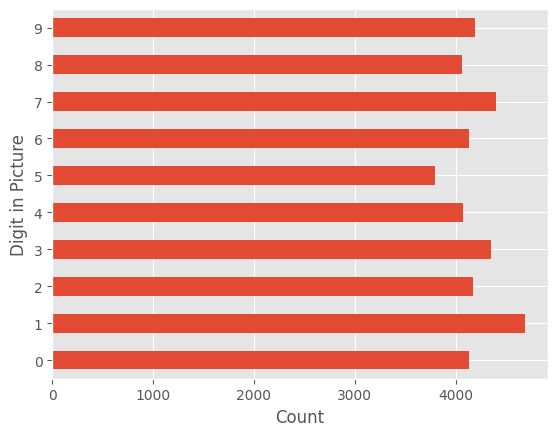

In [4]:
#getting the count of each digit in our training dataset

plt.style.use("ggplot")
plt.figure()
X_label.value_counts().sort_index().plot(kind='barh')
plt.ylabel("Digit in Picture")
plt.xlabel("Count")
plt.show()

In [5]:
#to get an understanding of our data lets look at the shape
X.shape, X_label.shape


((42000, 784), (42000,))

In [6]:
#to get the data to be passed in a CNN we will have to reshape the data to form 28x28 arrays
X = X.values.reshape(-1,28,28,1)
test = test_df.values.reshape(-1,28,28,1)

In [7]:
#ensuring our data was properly reshaped
X.shape, X_label.shape

((42000, 28, 28, 1), (42000,))

In [8]:
#the data is still not normalized the pixel values still go from 0-255.  So we will need to scale these to be from 0-1

# Normalize the data
X, test = X / 255.0, test / 255.0

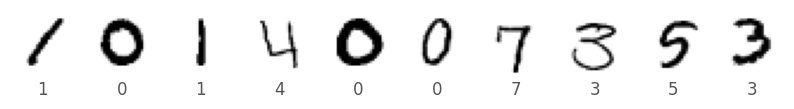

In [9]:
#lets print out the first few pictures to get an idea of what our data looks like with the respective labels

num_images = 10
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(X_label[i])
plt.show()


In [10]:
#before we build the model we can train the model with a smaller subset of data to decrease time (if desired)

SMALLER_SUBET_SIZE = 28000

random_indices = np.random.choice(28000, SMALLER_SUBET_SIZE, replace=False)
X_smaller = X[random_indices]
X_label_smaller = X_label[random_indices]



In [11]:
# Splitting the train data into train and validation sets
X_smaller_train, X_val, X_label_smaller_train, y_val = train_test_split(X_smaller, X_label_smaller, test_size=0.2)


In [12]:
# Build the model

EPOCHS = 3
BATCH_SIZE = 64

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=5,
                                 verbose=2,
                                 factor=.75)

# If score doesn't improve during patience=10 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss',
                          patience=10,
                          verbose=2)



In [13]:
#Fitting the model
history = model.fit(X_smaller_train, X_label_smaller_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_val, y_val), callbacks = [lr_reduction, estopping])


Epoch 1/3


350/350 [==============================] - 31s 81ms/step - loss: 0.2076 - accuracy: 0.9350 - val_loss: 0.0735 - val_accuracy: 0.9791 - lr: 0.0010
Epoch 2/3
350/350 [==============================] - 27s 77ms/step - loss: 0.0537 - accuracy: 0.9829 - val_loss: 0.0986 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 3/3
350/350 [==============================] - 28s 79ms/step - loss: 0.0334 - accuracy: 0.9892 - val_loss: 0.0694 - val_accuracy: 0.9784 - lr: 0.0010


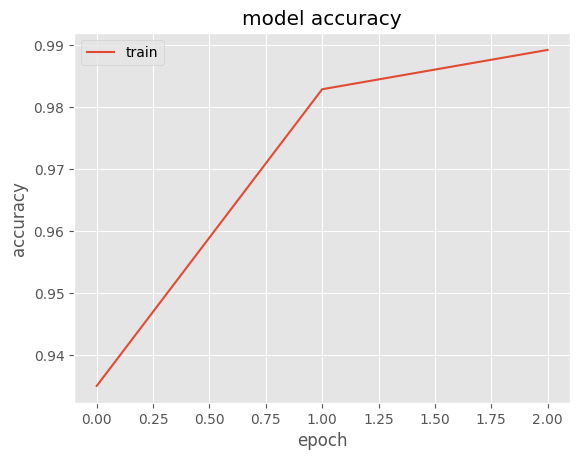

In [14]:
# history for accuracy while training the model
plt.plot(history.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

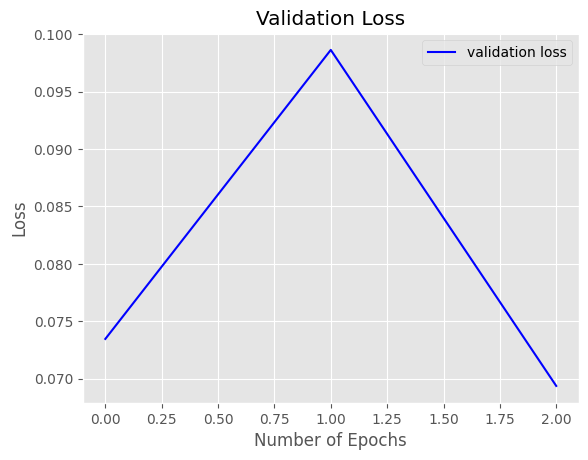

In [15]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

175/175 [==============================] - 3s 15ms/step


Text(0.5, 1.0, 'Confusion Matrix')

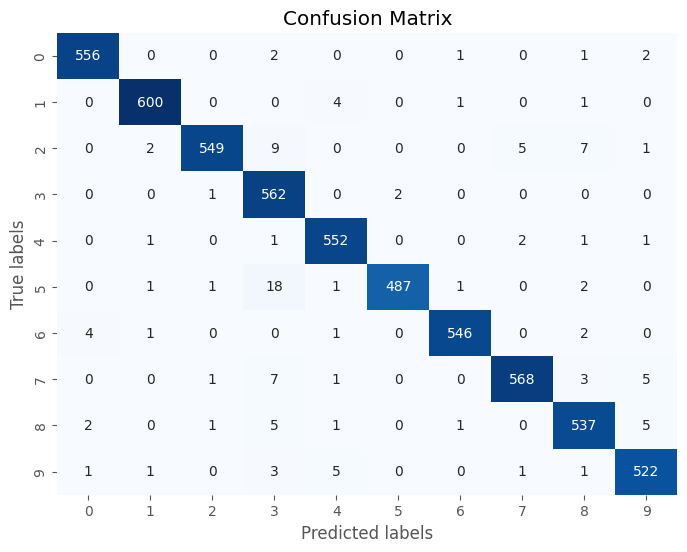

In [16]:
#setting up the confusion matrix with the validation data

#using the model to predict the number with test data
y_pred = np.argmax(model.predict(X_val), axis=-1)

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [17]:
#make a predictions variable from passing the test data through the trained model
predictions = model.predict(test)

875/875 [==============================] - 15s 17ms/step


In [18]:
#notice how these numbers are all super small except for index 2 (this means according to the model is most confident index 2 is the most probable number) 
predictions[0]

array([8.0500018e-10, 2.9827133e-12, 9.9999928e-01, 2.6365731e-07,
       1.0641387e-11, 4.8101859e-14, 4.3191959e-15, 4.5726176e-07,
       3.2569039e-09, 2.7796168e-12], dtype=float32)

In [19]:
#updating the highest probabilty label in the predicions series as the predicted label
predictions = np.argmax(predictions,axis = 1)
predictions = pd.Series(predictions,name = "Label")

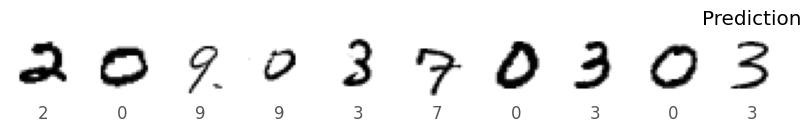

In [20]:
#printing out a few predicitons with their true labels

num_images = 10

plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i], cmap=plt.cm.binary)
    plt.xlabel(predictions[i])
plt.title("Prediction")
plt.show()


In [21]:
#formatted submission to the Kaggle competition
submission['Label'] = predictions
submission.head()


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
